In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt
from time import time

In [2]:
#   CARGA DE HDF5
# ==============================
# CARGA DIRECTA DE TRAIN/VAL
h5_train = h5py.File("train_128.h5", "r") #se cargan los ficheros por separado para poder subirlos a colab sin que de error
train_images = h5_train["images"]
train_labels = h5_train["labels"]

h5_val = h5py.File("val_128.h5", "r")
val_images = h5_val["images"]
val_labels = h5_val["labels"]

print("Train:", train_images.shape, "Val:", val_images.shape)

Train: (12372, 128, 128, 3) Val: (2651, 128, 128, 3)


In [3]:
# MIXED PRECISION (Activa el entrenamiento con precisión mixta (float16 en la mayoría de las operaciones), 
# lo que acelera entrenamiento en GPUs modernas (Tensor Cores) y reduce uso de memoria.)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [4]:
tipos_galaxia = {
    0: "spiral",
    1: "elliptical",
    2: "lenticular",
    3: "irregular",
    4: "merger",
    5: "unknown",
    6: "barred spiral",
    7: "compact",
    8: "edge-on",
    9: "uncertain"
} #el dataset no ofrece la equivalencia y las etiquetas solo son numeros, por eso recurrimos a la docuentación oficial del dataset para hacer la lista manualmente

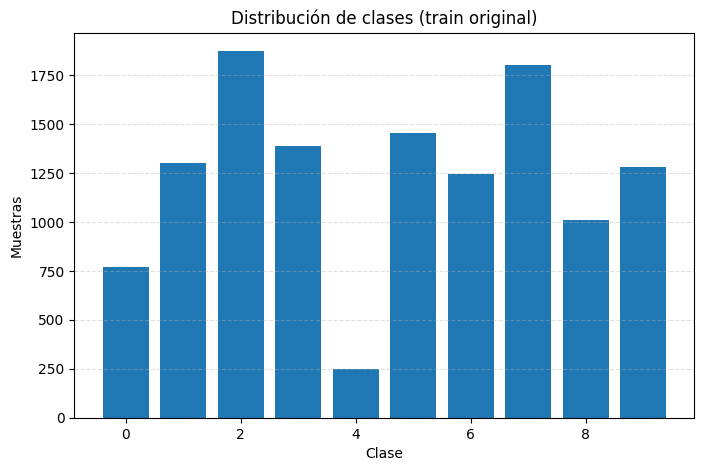

In [5]:
# DISTRIBUCIÓN ORIGINAL EN TRAIN
classes, counts = np.unique(train_labels, return_counts=True)
plt.figure(figsize=(8,5))
plt.bar(classes, counts)
plt.title("Distribución de clases (train original)")
plt.xlabel("Clase")
plt.ylabel("Muestras")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.show()

In [6]:
# BALANCEO OFFLINE (sobre índices de train) aplicamos tecnicas de oversample/undersample para corregir desbalanceo
unique_classes, counts = np.unique(train_labels, return_counts=True)

min_target = 1200 #target final de numero de imagenes por clase
balanced_indices = []

for c, cnt in zip(unique_classes, counts): #bucle que comprueba si el numero de imagenes es mayor o menor que el target, entonces o crea imagenes o elimina segun el caso.
    class_idx = np.where(train_labels[:] == c)[0]
    if cnt > min_target:
        sel = np.random.choice(class_idx, min_target, replace=False)
    else:
        sel = np.random.choice(class_idx, min_target, replace=True)
    balanced_indices.extend(sel)

balanced_indices = np.array(balanced_indices)
np.random.shuffle(balanced_indices)

print("Nuevo tamaño del train balanceado:", len(balanced_indices))

Nuevo tamaño del train balanceado: 12000


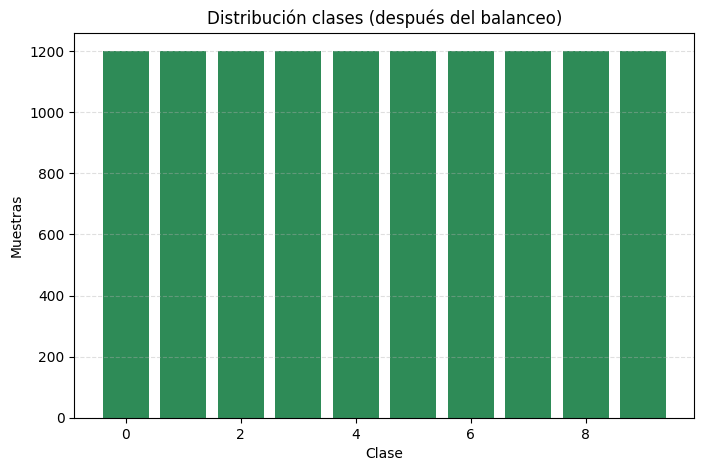

In [7]:
# DISTRIBUCIÓN TRAS BALANCEO
balanced_lbls = np.array([train_labels[i] for i in balanced_indices])
c2, cnt2 = np.unique(balanced_lbls, return_counts=True)

plt.figure(figsize=(8,5))
plt.bar(c2, cnt2, color="seagreen")
plt.title("Distribución clases (después del balanceo)")
plt.xlabel("Clase")
plt.ylabel("Muestras")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.show()

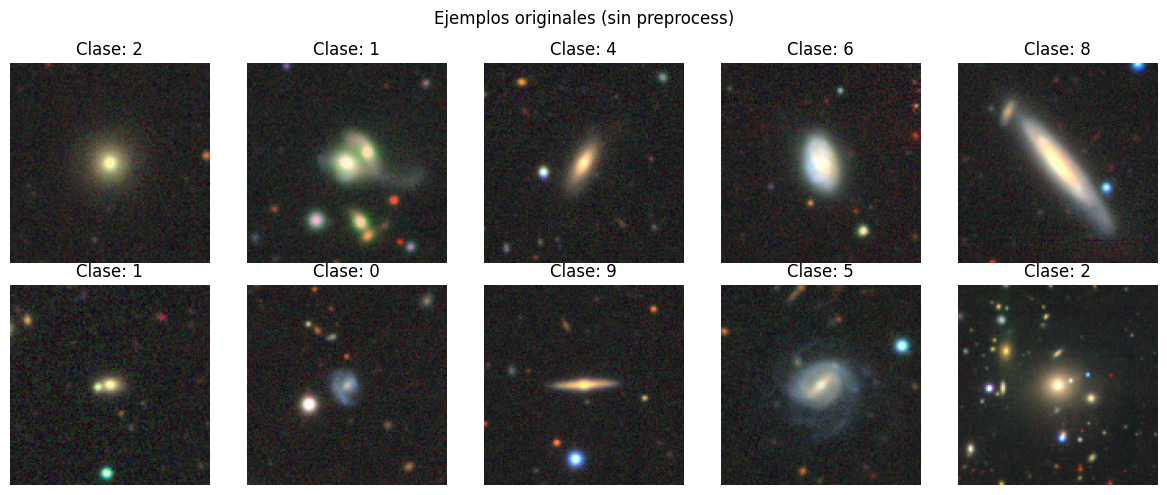

In [8]:
# Visualización directa desde HDF5 (sin preprocess)
idx = np.random.randint(0, len(train_images), 10)

plt.figure(figsize=(12,5))
for i, id_img in enumerate(idx):
    img = train_images[id_img]  # sin cast, sin preprocess
    lbl = train_labels[id_img]

    plt.subplot(2,5,i+1)
    plt.imshow(img)  # rango 0..255 correcto
    plt.title(f"Clase: {lbl}")
    plt.axis("off")

plt.suptitle("Ejemplos originales (sin preprocess)")
plt.tight_layout()
plt.show()

In [9]:
# PREPROCESADO Y DATASETS

from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = 224
batch_size = 64

def load_train(i):
    i = int(i)
    return train_images[i], train_labels[i]

def load_val(i):
    i = int(i)
    return val_images[i], val_labels[i]

def preprocess(i, mode="train"):  #fija la forma (128×128×3) y redimensiona a IMG_SIZE (224→ tamaño de entrada esperado por EfficientNet),
    if mode == "train":
        img, lbl = tf.py_function(load_train, [i], [tf.uint8, tf.int32])
    else:
        img, lbl = tf.py_function(load_val, [i], [tf.uint8, tf.int32])

        # Ajustamos el shape original de entrada
    img.set_shape([128,128,3])  # ← el dataset está en 128, dejamos esto igual
    lbl.set_shape([])

    # Resize EXACTAMENTE aquí
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    # Preprocesado para EfficientNet (aplicamos preprocess_input de EfficientNet (escala/normaliza).)
    img = preprocess_input(tf.cast(img, tf.float32))

    return img, lbl

In [10]:
# Augment solo imágenes (Creamos mas imagenes a partir de las originales)
aug_layers = tf.keras.Sequential([
    layers.RandomRotation(0.4), #como son galaxias, da igual la rotación y podemos tener mas margen que 0.1
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.15),
])

def augment(img, lbl):
    return aug_layers(img), lbl

In [11]:
#   CREACIÓN DE DATASETS con tf.data (solo imágenes)
def create_ds(indices, mode="train", aug=False): #Creamos un dataset a partir de índices (enteros) que indican qué imágenes leer dentro del archivo HDF5.
    ds = tf.data.Dataset.from_tensor_slices(indices)
    if mode=="train":
        ds = ds.shuffle(5000) #mezcla de dataset en training con shuffle
    ds = ds.map(lambda x: preprocess(x, mode), num_parallel_calls=tf.data.AUTOTUNE)
    if aug and mode=="train":
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE) #Mientras el modelo entrena un lote, TensorFlow prepara el siguiente lote en segundo plano → reduce tiempo de espera.
    return ds

'''
Cada índice x pasa por preprocess(...), que:
Lee la imagen del HDF5
Redimensiona a 224x224
Aplica preprocess_input de EfficientNet
Devuelve (imagen procesada, etiqueta)
num_parallel_calls=tf.data.AUTOTUNE → TensorFlow usa los núcleos del procesador para acelerar el mapeo.
'''
train_ds = create_ds(balanced_indices, mode="train", aug=True) #creamos los lotes en train y val y con aumento de imagenes en train
val_indices = np.arange(len(val_images))
val_ds = create_ds(val_indices, mode="val", aug=False)

In [12]:
#   MODELO EfficientNetB0 (solo imágenes)
img_input = Input(shape=(224,224,3))
base = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=img_input) #definimos nosotros mismos las capas neuronales, no las de EfficientNetB0
base.trainable = False
for layer in base.layers[-100:]: #congela la mayoria de las capas pero descongela las 100 últimas para mejorar via fine tuning
    layer.trainable = True

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.3)(x) #reducimos el overfitting con dropout
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
out = layers.Dense(10, activation="softmax", dtype="float32")(x) #diez capas de salida para cada clase de galaxia 

model = Model(inputs=img_input, outputs=out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), #learning rate bajo pero eficiente con el descongelamiento de las ultimas capas.
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,419,309 (16.86 MB)

 Trainable params: 3,847,870 (14.68 MB)

 Non-trainable params: 571,439 (2.18 MB)

In [ ]:
# ENTRENAMIENTO
from tensorflow.keras.callbacks import EarlyStopping

# Callbacks EarlyStopping detiene entrenamiento si val_loss no mejora después de 10 épocas, restaurando mejores pesos.
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau( #reduce la lr cuando val_loss se estanca (útil en fine-tuning).
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

t0 = time()
history = model.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds,
    callbacks=[early, lr_schedule]
)
print("Tiempo:", round(time()-t0,2), "seg")



Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.1084 - loss: 2.3414 - val_accuracy: 0.1652 - val_loss: 2.2590 - learning_rate: 1.0000e-05
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 156s 828ms/step - accuracy: 0.1277 - loss: 2.2893 - val_accuracy: 0.2429 - val_loss: 2.1592 - learning_rate: 1.0000e-05
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 155s 827ms/step - accuracy: 0.1773 - loss: 2.2181 - val_accuracy: 0.3350 - val_loss: 1.9927 - learning_rate: 1.0000e-05
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 150s 796ms/step - accuracy: 0.2583 - loss: 2.1030 - val_accuracy: 0.3806 - val_loss: 1.7800 - learning_rate: 1.0000e-05
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 201s 790ms/step - accuracy: 0.3558 - loss: 1.9337 - val_accuracy: 0.4379 - val_loss: 1.5434 - learning_rate: 1.0000e-05
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 148s 786ms/step - accuracy: 0.4220 - loss: 1.7152 - val_accuracy: 0.4975 - val_loss: 1.3647 - learning_rate: 1.0000e-05
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 209

In [13]:
#   EVALUACIÓN EN TEST (Con carga de fichero H5)

IMG_SIZE =224
h5_test = h5py.File("test_128.h5", "r")
test_images = h5_test["images"]
test_labels = h5_test["labels"]

test_idx = np.arange(len(test_images))

def load_test(i):
    i = int(i)
    return test_images[i], test_labels[i]

def preprocess_test(i):
    img, lbl = tf.py_function(load_test, [i], [tf.uint8, tf.int32])

    img.set_shape([128, 128, 3]) 
    lbl.set_shape([])

    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))  #resize a 224 para que sea compatible en el modelo.
    img = preprocess_input(tf.cast(img, tf.float32))  # Mismo preprocesado que train

    return img, lbl

test_ds = (tf.data.Dataset.from_tensor_slices(test_idx)
           .map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))

In [14]:
y_true, y_pred = [], []

for imgs, lbls in test_ds:
    preds = model.predict(imgs)
    y_true.extend(lbls.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Usamos directamente tipos_galaxia
inverse_map = tipos_galaxia

y_true_labels = [inverse_map[int(x)] for x in y_true.ravel()]
y_pred_labels = [inverse_map[int(x)] for x in y_pred.ravel()]

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step


KeyboardInterrupt: 

In [15]:
# Evaluar el modelo directamente sobre el dataset de test
loss, accuracy = model.evaluate(test_ds)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

 2/42 ━━━━━━━━━━━━━━━━━━━━ 3:53 6s/step - accuracy: 0.1602 - loss: 2.3012

KeyboardInterrupt: 

               precision    recall  f1-score   support

barred spiral       0.70      0.76      0.73       290
      compact       0.71      0.55      0.62       400
      edge-on       0.85      0.92      0.88       204
   elliptical       0.82      0.84      0.83       258
    irregular       0.90      0.88      0.89       318
   lenticular       0.89      0.93      0.91       379
       merger       0.50      0.92      0.65        38
       spiral       0.45      0.45      0.45       158
    uncertain       0.93      0.91      0.92       288
      unknown       0.77      0.81      0.79       319

     accuracy                           0.79      2652
    macro avg       0.75      0.79      0.77      2652
 weighted avg       0.79      0.79      0.79      2652



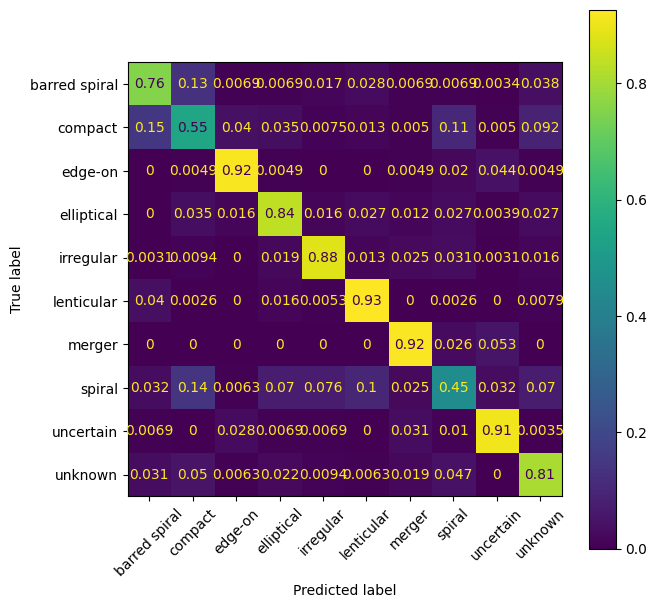

In [78]:
print(classification_report(y_true_labels, y_pred_labels))


fig, ax = plt.subplots(figsize=(7, 7))

# Mostrar la matriz de confusión normalizada
ConfusionMatrixDisplay.from_predictions(
    y_true_labels,
    y_pred_labels,
    normalize="true",
    #cmap="Blues",
    ax=ax
)

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()

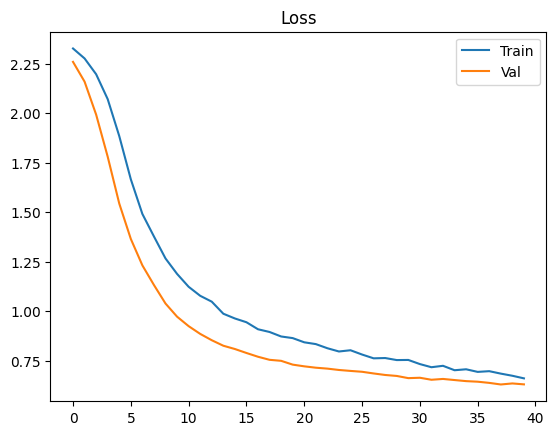

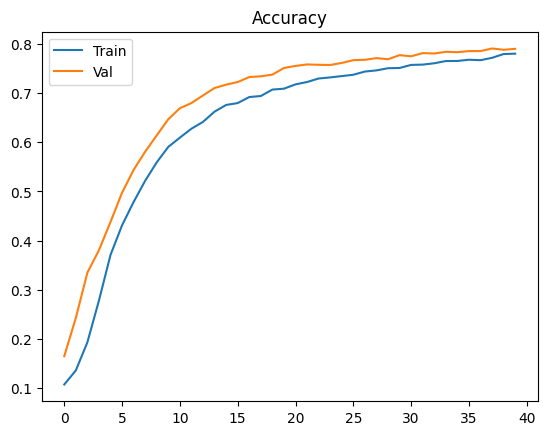

In [79]:
# CURVAS DE ENTRENAMIENTO
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.legend(); plt.title("Loss")
plt.show()

plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.legend(); plt.title("Accuracy")
plt.show()

In [48]:
#   GUARDAR MODELO
model.save("/content/modelo_galaxias.keras")